In [110]:
import sqlite3
import pandas as pd
import struct
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
import joblib

### Vectorización de audio features

In [111]:
def load_data():
    """ Lee features de la base de datos features.db"""

    features_db_path = "dataset/features.db"
    genres_db_path = "dataset/genres.db"
    metadata_db_path = "dataset/metadata.db"
    tags_db_path = "dataset/tags.db"

    conn = sqlite3.connect(features_db_path)
    features_df = pd.read_sql_query("SELECT * FROM features", conn)
    conn.close()

    conn = sqlite3.connect(genres_db_path)
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()

    conn = sqlite3.connect(metadata_db_path)
    metadata_df = pd.read_sql_query("SELECT * FROM metadata", conn)
    conn.close()

    conn = sqlite3.connect(tags_db_path)
    tags_df = pd.read_sql_query("SELECT * FROM tags", conn)
    conn.close()

    if not os.path.exists("models"):
        os.makedirs("models")

    return features_df, genres_df, metadata_df, tags_df

features_df, genres_df, metadata_df, tags_df = load_data()

In [112]:
def decode_tempo(b):
    try:
        if isinstance(b, float):
            return b
        if isinstance(b, (bytes, bytearray)) and len(b) == 4:
            return struct.unpack('f', b)[0]  # <-- 'f' = float32 (4 bytes)
        if isinstance(b, str) and ',' in b:
            byte_list = list(map(int, b.split(',')))
            b = bytes(byte_list)
            return struct.unpack('f', b)[0]
    except Exception as e:
        print(f"⚠️ decode_tempo falló con {repr(b)}: {e}")
    return np.nan

def decode_array(b):
    try: 
        return np.frombuffer(b, dtype=np.float32)
    except Exception:
        return b

def concat_full_vector():
    """Concatena en un solo vector datos de features, genres y tags"""
    df = pd.concat([features_df, genres_df, tags_df], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True)
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        row_copy = row.drop(labels=['mfcc_mean', 'tempo', 'stft_mean', 'chroma_mean'], errors = "ignore").copy()
        other_features = row_copy.values.astype(np.float32)
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo, other_features])
        vectors.append(full_vector)
    return np.stack(vectors)

def concat_vector():
    """"Concatena en un solo vector datos de features solo"""
    df = features_df.copy()
    df.drop(columns=['clip_id', 'mp3_path'], inplace=True)
    df.dropna(inplace=True) 
    df['tempo'] = df['tempo'].apply(decode_tempo)
    df['mfcc_mean'] = df['mfcc_mean'].apply(decode_array)
    df['chroma_mean'] = df['chroma_mean'].apply(decode_array)
    df['stft_mean'] = df['stft_mean'].apply(decode_array)
    vectors = []
    for _, row in df.iterrows():
        mfcc = row['mfcc_mean']
        tempo = np.array([row['tempo']], dtype=np.float32)
        chroma = row['chroma_mean']
        stft = row['stft_mean']
        full_vector = np.concatenate([stft, mfcc, chroma, tempo])
        vectors.append(full_vector)
    return np.stack(vectors)

vectors = concat_vector()
full_vectors = concat_full_vector()
print(vectors.shape)
print(vectors[0].shape)
print(full_vectors.shape)
print(full_vectors[0].shape)

(17783, 1051)
(1051,)
(17783, 1146)
(1146,)


### Normalización

In [113]:
scaler = StandardScaler()
X = scaler.fit_transform(vectors)
X_full = scaler.fit_transform(full_vectors)

In [114]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
X_full_train, X_full_test = train_test_split(X_full, test_size=0.2, random_state=42)

### Análisis de componentes principales (PCA)

In [115]:
pca = PCA(n_components = 128)
X_pca = pca.fit(X_train)

X_pca_test = pca.transform(X_test)
explained_var_ratio = pca.explained_variance_ratio_
cumulative_variance  = np.cumsum(explained_var_ratio)

print(f"Varianza explicada total (128D): {cumulative_variance[-1]*100:.2f}%")
print("Primeras 10 componentes (varianza explicada):")
print(np.round(explained_var_ratio[:10] * 100, 2)) 

X_reconstructed = pca.inverse_transform(X_pca_test)
mse_reconstruction = np.mean(np.power(X_test - X_reconstructed, 2), axis=1)
mae_reconstruction = np.mean(np.abs(X_test - X_reconstructed), axis=1)
rmse_reconstruction = np.sqrt(mse_reconstruction)

print(f"MSE: {mse_reconstruction.mean()} ± {mse_reconstruction.std()}")
print(f"RMSE: {rmse_reconstruction.mean()} ± {rmse_reconstruction.std()}")
print(f"MAE: {mae_reconstruction.mean()} ± {mae_reconstruction.std()} \n")


Varianza explicada total (128D): 92.70%
Primeras 10 componentes (varianza explicada):
[43.37  7.98  5.31  3.    1.88  1.5   1.28  1.08  0.98  0.92]
MSE: 0.08468157798051834 ± 0.4780063033103943
RMSE: 0.20000772178173065 ± 0.21137283742427826
MAE: 0.114619679749012 ± 0.12420965731143951 



In [116]:
pca_full = PCA(n_components = 128)
X_pca = pca_full.fit(X_full_train)

X_pca_test = pca_full.transform(X_full_test)
explained_var_ratio = pca_full.explained_variance_ratio_
cumulative_variance_full  = np.cumsum(explained_var_ratio)

print(f"Varianza explicada total (128D): {cumulative_variance_full[-1]*100:.2f}%")
print("Primeras 10 componentes (varianza explicada):")
print(np.round(explained_var_ratio[:10] * 100, 2)) 

X_reconstructed = pca_full.inverse_transform(X_pca_test)
mse_reconstruction = np.mean(np.power(X_full_test - X_reconstructed, 2), axis=1)
mae_reconstruction = np.mean(np.abs(X_full_test - X_reconstructed), axis=1)
rmse_reconstruction = np.sqrt(mse_reconstruction)

print(f"MSE: {mse_reconstruction.mean()} ± {mse_reconstruction.std()}")
print(f"RMSE: {rmse_reconstruction.mean()} ± {rmse_reconstruction.std()}")
print(f"MAE: {mae_reconstruction.mean()} ± {mae_reconstruction.std()} \n")

Varianza explicada total (128D): 86.74%
Primeras 10 componentes (varianza explicada):
[39.93  7.36  4.9   2.78  1.76  1.39  1.18  0.99  0.9   0.85]
MSE: 0.15126672387123108 ± 0.6628231406211853
RMSE: 0.3096470236778259 ± 0.23534110188484192
MAE: 0.15533968806266785 ± 0.13198520243167877 



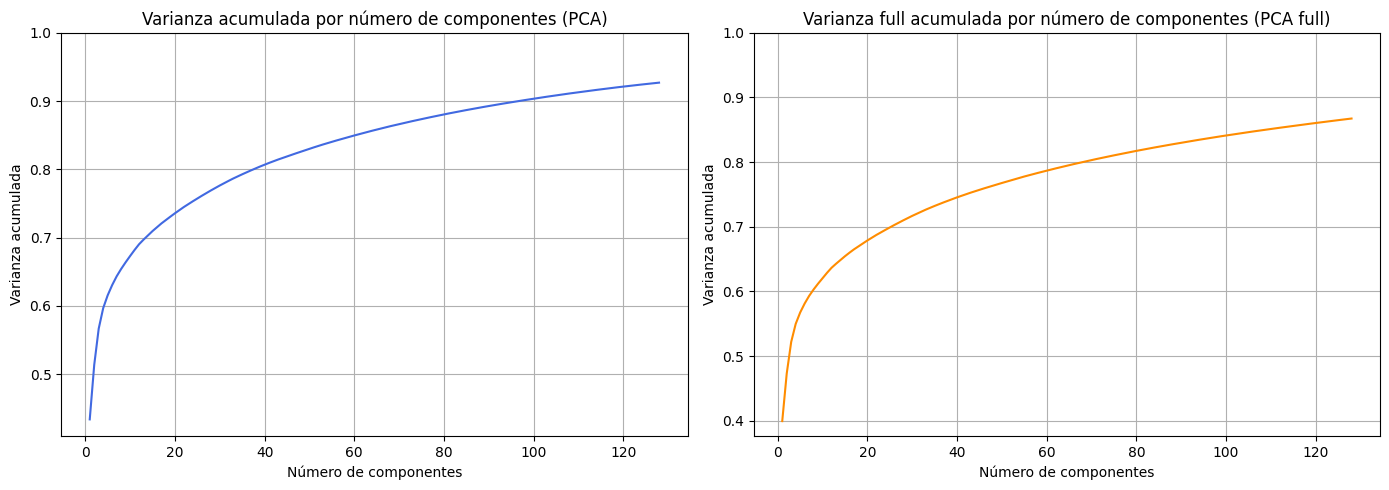

In [117]:
plt.figure(figsize=(14, 5))

# Subplot 1: Varianza acumulada (normal)
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, 129), cumulative_variance[:128], color='royalblue')
plt.title("Varianza acumulada por número de componentes (PCA)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.ylim(top=1)
plt.grid(True)

# Subplot 2: Varianza acumulada (full)
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, 129), cumulative_variance_full[:128], color='darkorange')
plt.title("Varianza full acumulada por número de componentes (PCA full)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.ylim(top=1)
plt.grid(True)

plt.tight_layout()
plt.show()

### Autoencoders

#### Autoencoder simple (AE)

In [118]:
def build_autoencoder(input_dim, latent_dim):
    """Construye un autoencoder simple"""
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(latent_dim, activation='relu')(encoded)

    decoded = Dense(512, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)

    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

In [119]:
autoencoder, encoder = build_autoencoder(input_dim=X.shape[1], latent_dim=128)
print(encoder.summary())

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1051)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 512)            │       538,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 128)            │        65,664 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 604,288 (2.31 MB)

 Trainable params: 604,288 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

None


In [120]:
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test) )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6643 - val_loss: 0.3943
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3744 - val_loss: 0.3129
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3007 - val_loss: 0.2762
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2648 - val_loss: 0.2384
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2253 - val_loss: 0.2191
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2068 - val_loss: 0.2087
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1921 - val_loss: 0.2270
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2044 - val_loss: 0.2063
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1838 - val_loss: 0.1877
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1559 - val_loss: 0.1745
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1457 - val_loss: 0.1650
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1464 - val

In [121]:
autoencoder_full, encoder_full = build_autoencoder(input_dim=X_full.shape[1], latent_dim=128)
autoencoder_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test) )

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6633 - val_loss: 0.4361
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4116 - val_loss: 0.3634
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3489 - val_loss: 0.3120
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3014 - val_loss: 0.2962
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2830 - val_loss: 0.2719
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2532 - val_loss: 0.2557
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2257 - val_loss: 0.2467
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2186 - val_loss: 0.2327
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2059 - val_loss: 0.2223
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1951 - val_loss: 0.2163
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1891 - val_loss: 0.2138
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1

In [122]:
# Evaluación de los autoencoders
decoded_vectors = autoencoder.predict(X_test)
decoded_full_vectors = autoencoder_full.predict(X_full_test)
# MSE
mse_vectors = np.mean(np.power(X_test - decoded_vectors, 2), axis=1)
mse_full_vectors = np.mean(np.power(X_full_test - decoded_full_vectors, 2), axis=1)
# MAE
mae_vectors = np.mean(np.abs(X_test - decoded_vectors), axis=1)
mae_full_vectors = np.mean(np.abs(X_full_test - decoded_full_vectors), axis=1)
# RMSE
rmse_vectors = np.sqrt(mse_vectors)
rmse_full_vectors = np.sqrt(mse_full_vectors)
print(f"MSE: {mse_vectors.mean()} ± {mse_vectors.std()}")
print(f"RMSE: {rmse_vectors.mean()} ± {rmse_vectors.std()}")
print(f"MAE: {mae_vectors.mean()} ± {mae_vectors.std()} \n")

print(f"MSE full: {mse_full_vectors.mean()} ± {mse_full_vectors.std()}")
print(f"RMSE full: {rmse_full_vectors.mean()} ± {rmse_full_vectors.std()}")
print(f"MAE full: {mae_full_vectors.mean()} ± {mae_full_vectors.std()}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MSE: 0.09644147008657455 ± 0.47720009088516235
RMSE: 0.21918700635433197 ± 0.21999666094779968
MAE: 0.14632640779018402 ± 0.14229533076286316 

MSE full: 0.12290526181459427 ± 0.4471428096294403
RMSE full: 0.2734554409980774 ± 0.21937954425811768
MAE full: 0.17479698359966278 ± 0.14168183505535126


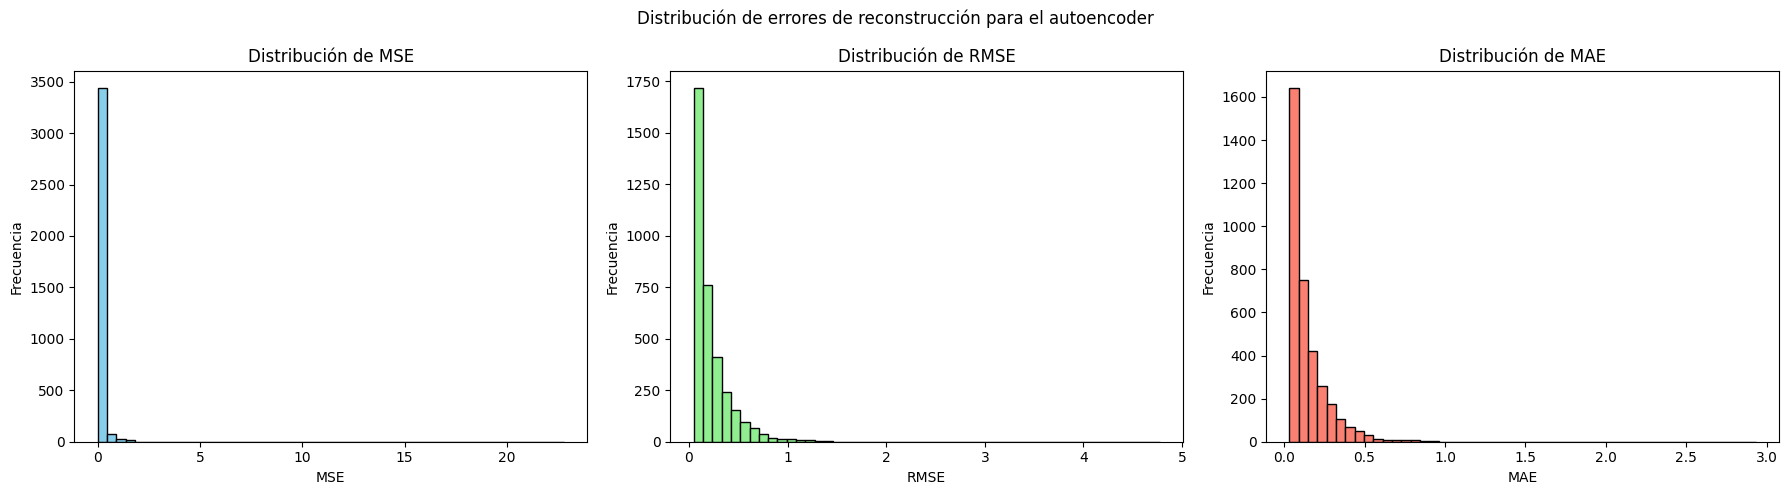

In [123]:
plt.figure(figsize=(18, 5))
plt.suptitle('Distribución de errores de reconstrucción para el autoencoder')
plt.subplot(1, 3, 1)
plt.hist(mse_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

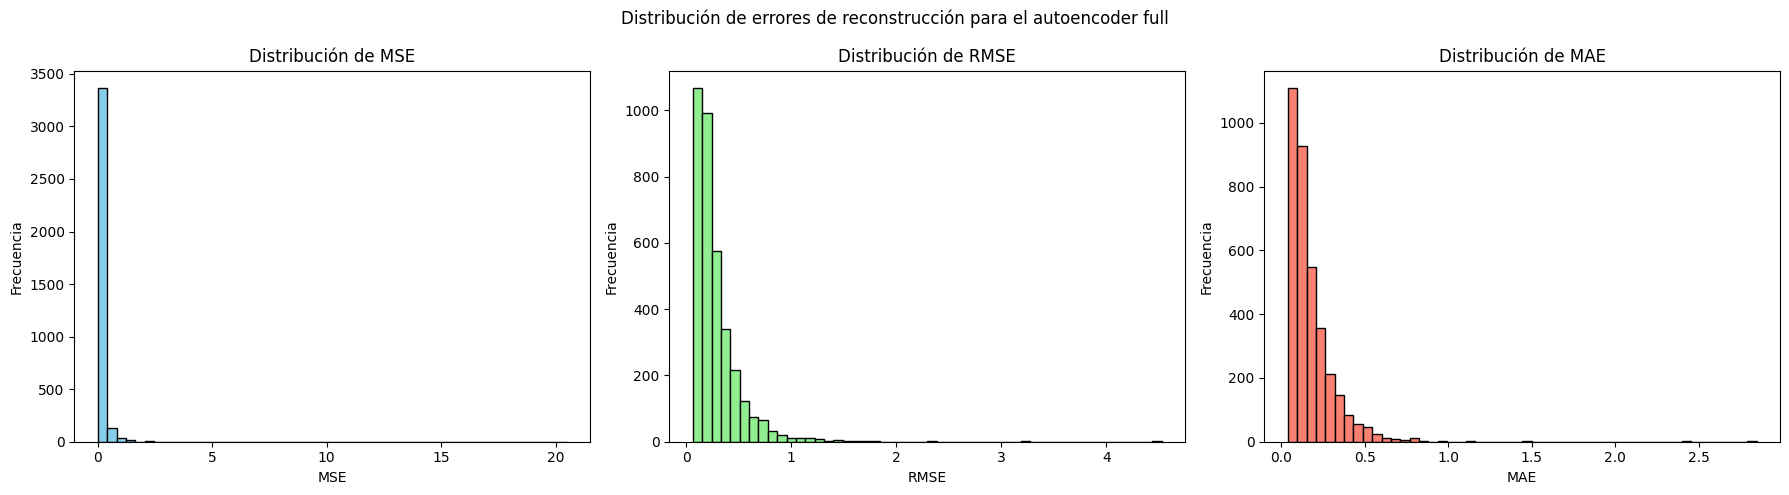

In [124]:
plt.figure(figsize=(18, 5))
plt.suptitle('Distribución de errores de reconstrucción para el autoencoder full')
plt.subplot(1, 3, 1)
plt.hist(mse_full_vectors, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_full_vectors, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_full_vectors, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Se puede observar que para las tres distribuciones (MSE, RMSE, MAE), la mayoría de muestras tienen errores bajos, y solamente unas pocas tienen errores altos, lo que nos indica que son posibles outliers o ejemplos difíciles de reconstruir.

🟦 Distribución por MSE:
- Se ve un pico pronunciado cerca del 0, es decir, la mayoría de entradas se han reconstruído correctamente
- Tenemos unos cuantos ejemplos con MSE > 1 y algunos extremos que podrían ser anomalías o errores en la reconstrucción

🟩 Distribución de RMSE:
- Muy parecida al MSE
- La mayoría está por debajo de 0.5, lo que es un buen signo

🟥 Distribución de MAE:
- La mayoría de errores son bajos (0 - 0.2)
- Es menos sensible a errores extremos, pero también hay algunos ejemplos con MAE > 2

In [125]:
umbral_rmse = 1.0
outliers = np.where(rmse_vectors > umbral_rmse)[0]
print(f'{len(outliers)} muestras con RMSE > {umbral_rmse}')

41 muestras con RMSE > 1.0


#### Variational Autoencoder (VAE)

In [126]:
class Sampling(tf.keras.layers.Layer):
    """Clase de muestreo para el VAE"""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def build_vae(input_dim, latent_dim):
    # Encoder
    inputs = Input(shape=(input_dim,), name='encoder_input')
    encoded = Dense(512, activation='relu')(inputs)
    z_mean = Dense(latent_dim, name='z_mean')(encoded)
    z_log_var = Dense(latent_dim, name='z_log_var')(encoded)
    z = Sampling(name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    h_decoded = Dense(512, activation='relu')(latent_inputs)
    outputs = Dense(input_dim, activation='sigmoid')(h_decoded)
    
    decoder = Model(latent_inputs, outputs, name='decoder')

    # VAE
    outputs = decoder(encoder(inputs)[2])  
    vae = Model(inputs, outputs, name='vae')

    return vae, encoder, decoder

def reconstruction_loss(x, x_decoded):
    return MeanSquaredError()(x, x_decoded)

def kl_loss(z_mean, z_log_var):
    return -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

def vae_loss(x, x_decoded, z_mean, z_log_var):
    r_loss = reconstruction_loss(x, x_decoded)
    k_loss = kl_loss(z_mean, z_log_var)
    return r_loss +  k_loss

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [127]:
vae, vae_encoder, vae_decoder = build_vae(input_dim=X.shape[1], latent_dim=128)

vae.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder(x)[0], vae_encoder(x)[1]))

vae.summary()
vae.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test), callbacks=[early_stopping])

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 1051)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 128), (None,   │       669,952 │
│                                 │ 128), (None, 128)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1051)           │       605,211 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,275,163 (4.86 MB)

 Trainable params: 1,275,163 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 133075800.0000 - val_loss: 6.4469
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.8833 - val_loss: 2.4035
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.3620 - val_loss: 1.9232
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8386 - val_loss: 1.8327
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7054 - val_loss: 1.6287
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5361 - val_loss: 1.4962
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3825 - val_loss: 1.4296
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4158 - val_loss: 1.3709
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2638 - val_loss: 1.3905
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2158 - val_loss: 1.3437
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2401 - val_loss: 1.3044
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - l

In [128]:
vae_full, vae_encoder_full, vae_decoder_full = build_vae(input_dim=X_full.shape[1], latent_dim=128)
vae_full.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder_full(x)[0], vae_encoder_full(x)[1]))
vae_full.fit(X_full_train, X_full_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_full_test, X_full_test), callbacks=[early_stopping])

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 10188483838607360.0000 - val_loss: 5.1900
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.8528 - val_loss: 2.3237
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.2395 - val_loss: 1.9378
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7658 - val_loss: 1.7965
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.6970 - val_loss: 1.6106
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4820 - val_loss: 1.6664
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.4950 - val_loss: 1.4683
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3193 - val_loss: 1.4176
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3623 - val_loss: 1.4793
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2483 - val_loss: 1.3490
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.3019 - val_loss: 1.3230
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/

### Evaluación

In [129]:
# Reconstrucción con VAE
decoded_vae_vectors = vae.predict(X_test)
decoded_vae_full_vectors = vae_full.predict(X_full_test)

# MSE
mse_vae = np.mean(np.power(X_test - decoded_vae_vectors, 2), axis=1)
mse_vae_full = np.mean(np.power(X_full_test - decoded_vae_full_vectors, 2), axis=1)

# MAE
mae_vae = np.mean(np.abs(X_test - decoded_vae_vectors), axis=1)
mae_vae_full = np.mean(np.abs(X_full_test - decoded_vae_full_vectors), axis=1)

# RMSE
rmse_vae = np.sqrt(mse_vae)
rmse_vae_full = np.sqrt(mse_vae_full)

print(f"VAE MSE: {mse_vae.mean()} ± {mse_vae.std()}")
print(f"VAE RMSE: {rmse_vae.mean()} ± {rmse_vae.std()}")
print(f"VAE MAE: {mae_vae.mean()} ± {mae_vae.std()} \n")

print(f"VAE MSE full: {mse_vae_full.mean()} ± {mse_vae_full.std()}")
print(f"VAE RMSE full: {rmse_vae_full.mean()} ± {rmse_vae_full.std()}")
print(f"VAE MAE full: {mae_vae_full.mean()} ± {mae_vae_full.std()}")

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
VAE MSE: 0.9572589993476868 ± 6.529134750366211
VAE RMSE: 0.6934130191802979 ± 0.6902443766593933
VAE MAE: 0.4940597116947174 ± 0.4325985014438629 

VAE MSE full: 0.9636861085891724 ± 5.988996505737305
VAE RMSE full: 0.7351536750793457 ± 0.6505652666091919
VAE MAE full: 0.47917982935905457 ± 0.3961713910102844


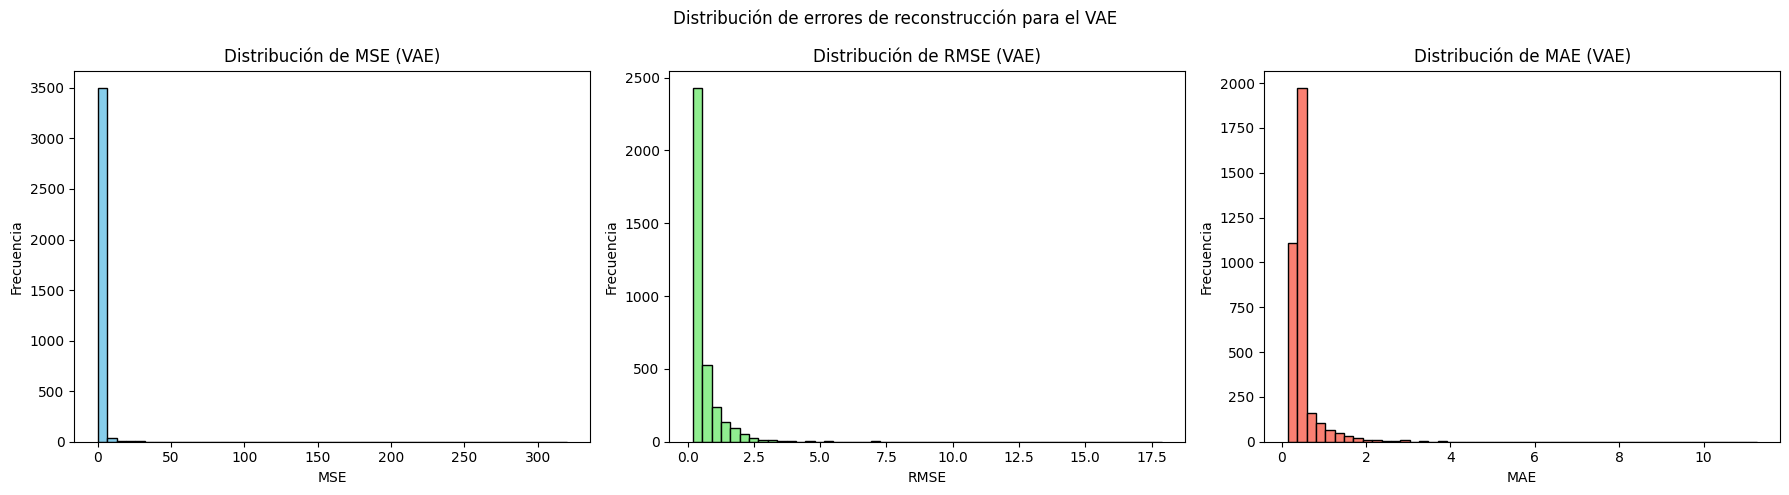

In [130]:
plt.figure(figsize=(18, 5))
plt.suptitle('Distribución de errores de reconstrucción para el VAE')
plt.subplot(1, 3, 1)
plt.hist(mse_vae, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE (VAE)')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vae, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE (VAE)')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vae, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE (VAE)')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

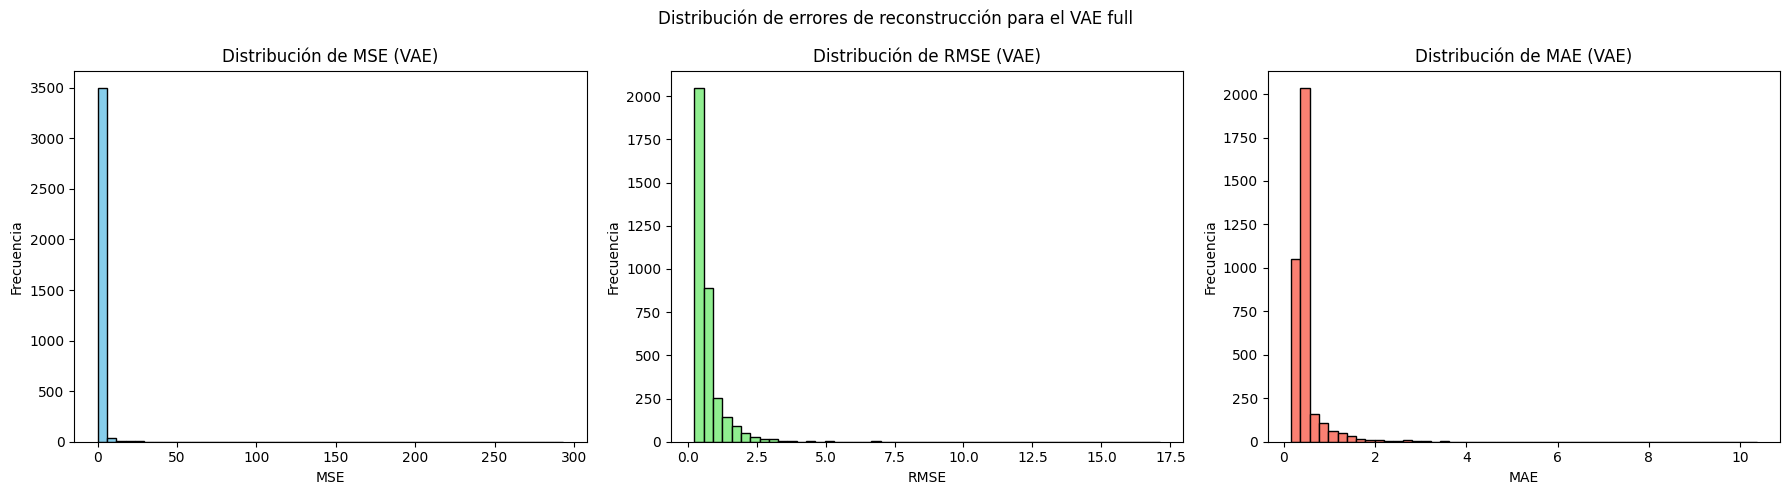

In [131]:
plt.figure(figsize=(18, 5))
plt.suptitle('Distribución de errores de reconstrucción para el VAE full')
plt.subplot(1, 3, 1)
plt.hist(mse_vae_full, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de MSE (VAE)')
plt.xlabel('MSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 2)
plt.hist(rmse_vae_full, bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribución de RMSE (VAE)')
plt.xlabel('RMSE')
plt.ylabel('Frecuencia')

plt.subplot(1, 3, 3)
plt.hist(mae_vae_full, bins=50, color='salmon', edgecolor='black')
plt.title('Distribución de MAE (VAE)')
plt.xlabel('MAE')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

A continuación vamos a comparar los errores en los cuatro casos.

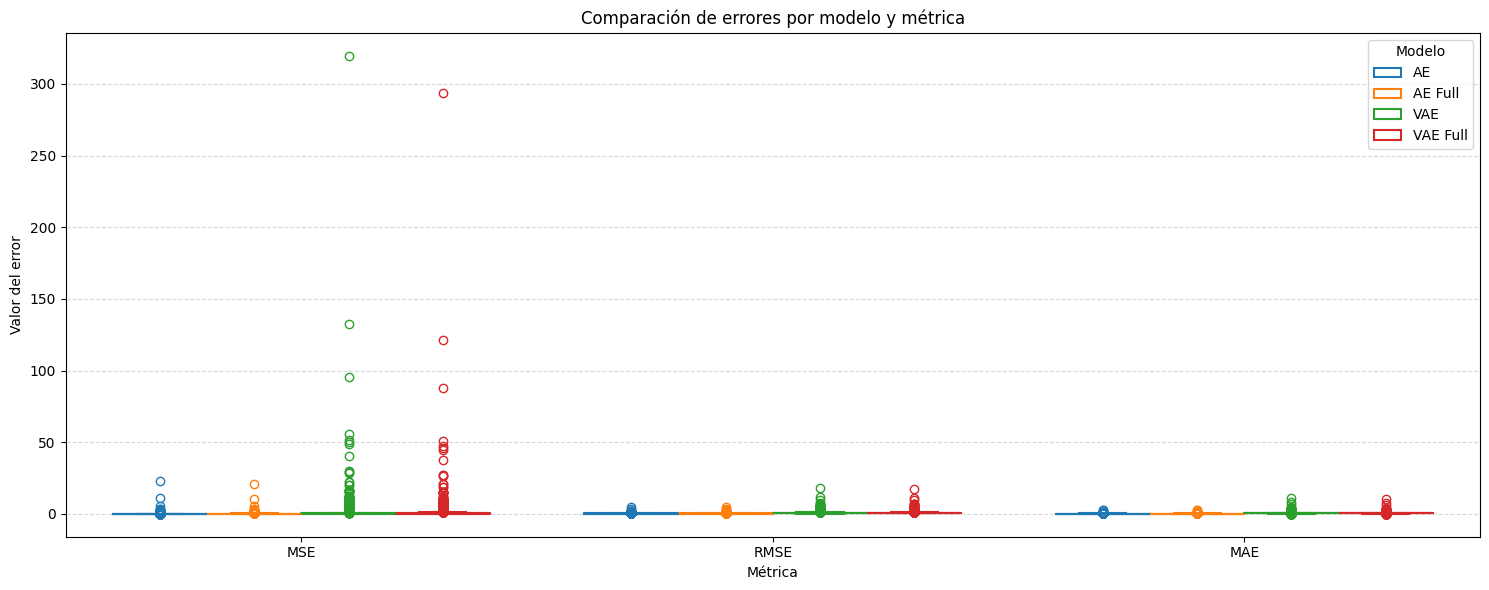

In [132]:
data = {
    'MSE': np.concatenate([mse_vectors, mse_full_vectors, mse_vae, mse_vae_full]),
    'RMSE': np.concatenate([rmse_vectors, rmse_full_vectors, rmse_vae, rmse_vae_full]),
    'MAE': np.concatenate([mae_vectors, mae_full_vectors, mae_vae, mae_vae_full]),
    'Modelo': ['AE'] * len(mse_vectors) + ['AE Full'] * len(mse_full_vectors) + ['VAE'] * len(mse_vae) + ['VAE Full'] * len(mse_vae_full)
}

df_mse = pd.DataFrame({'Error': data['MSE'], 'Métrica': 'MSE', 'Modelo': data['Modelo']})
df_rmse = pd.DataFrame({'Error': data['RMSE'], 'Métrica': 'RMSE', 'Modelo': data['Modelo']})
df_mae = pd.DataFrame({'Error': data['MAE'], 'Métrica': 'MAE', 'Modelo': data['Modelo']})
df_all = pd.concat([df_mse, df_rmse, df_mae], axis=0)

plt.figure(figsize=(15, 6))

sns.boxplot(data=df_all, x='Métrica', y='Error', hue='Modelo', fill=False)
plt.title('Comparación de errores por modelo y métrica')
plt.ylabel('Valor del error')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Entrenamiento final

Entrenamos finalmente nuestros modelos con todo el dataset.

In [133]:
pca.fit(X)
joblib.dump(pca, 'models/pca.pkl')

['models/pca.pkl']

In [134]:
pca_full.fit(X_full)
joblib.dump(pca_full, 'models/pca_full.pkl')

['models/pca_full.pkl']

In [135]:
autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True)
encoded_vectors = encoder.predict(X)
autoencoder.save("models/autoencoder.keras")
encoder.save("models/encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0862
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0860
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0904
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0909
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0761
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0779
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0713
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0737
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0845
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0717
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0794
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1060
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0761
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0836
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0849
Epoch 16/50
70/70 ━

In [136]:
autoencoder_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
encoded_full_vectors = encoder_full.predict(X_full)
autoencoder_full.save("models/autoencoder_full.keras")
encoder_full.save("models/encoder_full.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1020
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1306
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1392
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1348
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1333
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1285
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1227
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1237
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1434
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1121
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0951
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1412
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1084
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1110
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1061
Epoch 16/50
70/70 ━

In [137]:
vae.fit(X, X, epochs=50, batch_size=256, shuffle=True)
vae_encoded_vectors = vae_encoder.predict(X, batch_size=32)
vae.save("models/vae.keras")
vae_encoder.save("models/vae_encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2004
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0565
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1735
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1034
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0419
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0086
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0526
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0489
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1494
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0105
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0614
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0795
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0096
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0329
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0344
Epoc

c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder(x)[0], vae_encoder(x)[1]))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [138]:
vae_full.fit(X_full, X_full, epochs=50, batch_size=256, shuffle=True)
vae_encoded_full_vectors = vae_encoder_full.predict(X_full, batch_size=32)
vae_full.save("models/vae_full.keras")
vae_encoder_full.save("models/vae_full_encoder.keras")

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3052
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2613
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1787
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2184
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2011
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1395
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1850
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0936
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1914
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1322
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1837
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1372
Epoch 13/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1502
Epoch 14/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0365
Epoch 15/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1914
Epoc

c:\Users\pepea\Desktop\UNIVERSIDAD\CURSO 2024-2025\TFM-danarrarr\venv\Lib\site-packages\keras\src\saving\serialization_lib.py:390: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: vae_full.compile(optimizer=Adam(learning_rate=0.001, clipnorm=1.0), loss=lambda x, x_decoded: vae_loss(x, x_decoded, vae_encoder_full(x)[0], vae_encoder_full(x)[1]))

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [139]:
df_embeddings = pd.DataFrame({
    'clip_id': features_df['clip_id'].values,
    'original_embeddings': list(vectors),
    'encoded_embeddings': list(encoded_vectors),
    'original_full_embeddings': list(full_vectors),
    'encoded_full_embeddings': list(encoded_full_vectors),
    'vae_embeddings': list(vae_encoded_vectors[2]), # Hay 3 arrays, [z_mean, z_log_var, z]
    'vae_full_embeddings': list(vae_encoded_full_vectors[2]), # Hay 3 arrays, [z_mean, z_log_var, z]
})
df_embeddings.to_sql('embeddings', sqlite3.connect('dataset/embeddings.db'), if_exists='replace', index=False)

17783

In [140]:
def get_genres():
    """Obtiene los géneros de la base de datos"""
    conn = sqlite3.connect("dataset/genres.db")
    genres_df = pd.read_sql_query("SELECT * FROM genres", conn)
    conn.close()
    genres_df.drop(columns=['mp3_path'], inplace=True)

    genres_df = genres_df.melt(id_vars=['clip_id'], var_name='genre', value_name='value')
    genres_df = genres_df[genres_df['value'] == 1]
    genres_df = genres_df.drop(columns=['value'])

    genres_df = genres_df.groupby('clip_id')['genre'].apply(lambda x: list(x)).reset_index()
    genres_df.rename(columns={'genre': 'genres'}, inplace=True)
    genres_df['genres'] = genres_df['genres'].apply(lambda x: ', '.join(x))
    return genres_df


genres_df = get_genres()

all_genres = set()
for genre_str in genres_df['genres']:
    genres = [g.strip().lower() for g in genre_str.split(',')]
    all_genres.update(genres)

# Mapear géneros a posiciones lineales en [0, 1] y aplicar viridis
sorted_genres = sorted(all_genres)
genre_to_value = {genre: i / (len(sorted_genres) - 1) for i, genre in enumerate(sorted_genres)}
cmap = plt.get_cmap('gist_rainbow')
genre_colors = {genre: cmap(genre_to_value[genre]) for genre in sorted_genres}

def blend_colors(genre_list):
    colors = [np.array(genre_colors[g]) for g in genre_list if g in genre_colors]
    avg_color = np.mean(colors, axis=0)
    return tuple(avg_color)

# Asignar color mezclado a cada canción
clip_colors = []
for genre_str in genres_df['genres']:
    genres = [g.strip().lower() for g in genre_str.split(',')]
    mixed_color = blend_colors(genres)
    clip_colors.append(mixed_color)

In [141]:
# Visualización del espacio latente del autoencoder y el variational autoencoder
def plot_latent_space(latent_space_1, latent_space_2, title):
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.scatter(latent_space_1[:, 0], latent_space_1[:, 1], alpha=0.5, c=clip_colors)
    plt.title('Espacio Latente del Autoencoder')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.scatter(latent_space_2[:, 0], latent_space_2[:, 1], alpha=0.5, c=clip_colors)
    plt.title('Espacio Latente del VAE')
    plt.xlabel('Dimensión 1')
    plt.ylabel('Dimensión 2')
    plt.grid(True)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

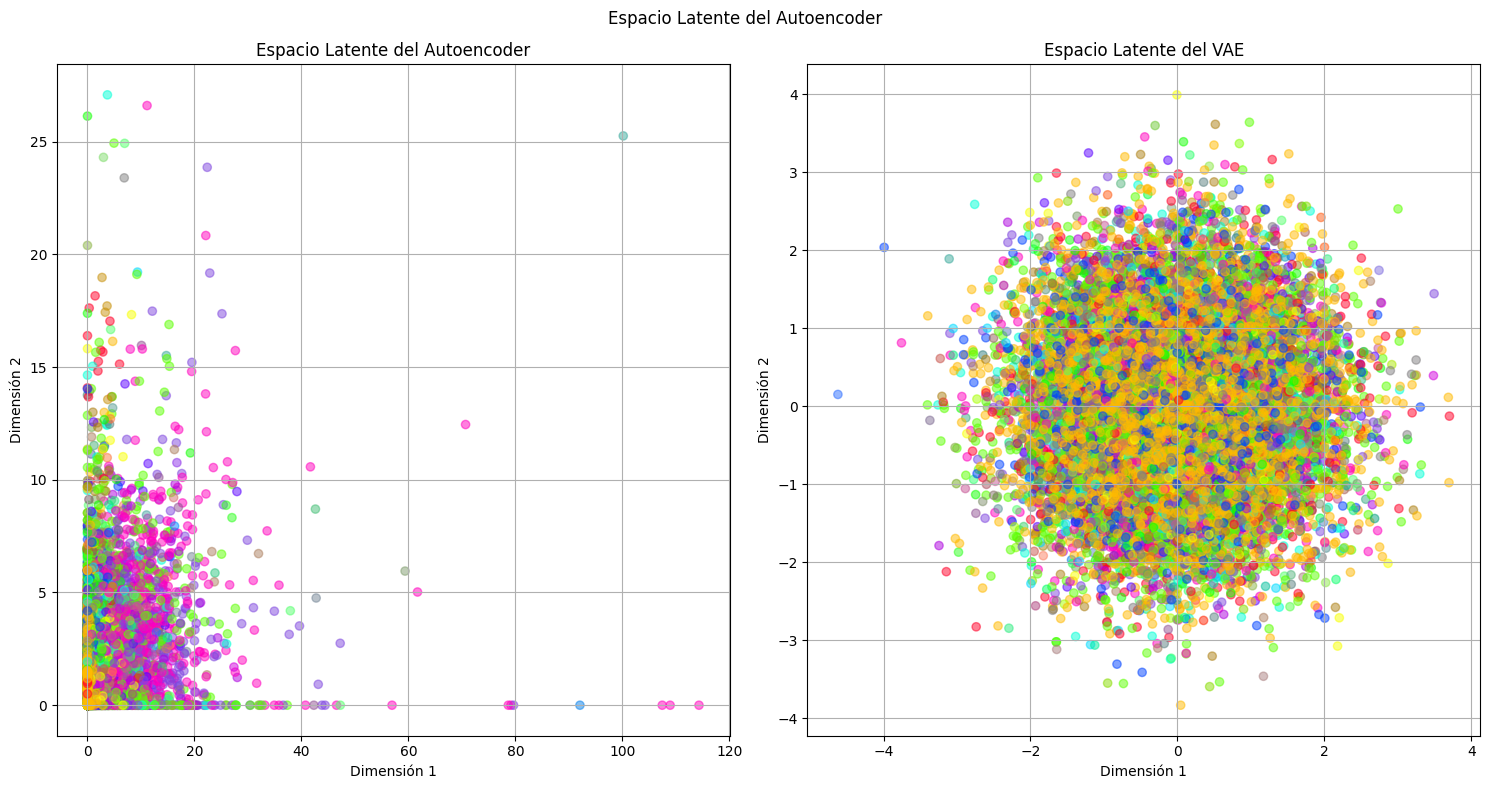

In [142]:
plot_latent_space(encoded_vectors, vae_encoded_vectors[2] ,'Espacio Latente del Autoencoder')